In [1]:
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt ## for figures
%matplotlib inline

## check pytorch version
torch.__version__

'2.5.1+cu121'

In [5]:
words = open('names.txt', 'r').read().splitlines()
words[:8]

['emma', 'olivia', 'ava', 'isabella', 'sophia', 'charlotte', 'mia', 'amelia']

In [6]:
len(words)

32033

In [7]:
### build vocab
chars = sorted(list(set(''.join(words))))
stoi = {s:i + 1 for i,s in enumerate(chars)}
stoi['.'] = 0
itos = {i:s for s,i in stoi.items()}
print(itos)

{1: 'a', 2: 'b', 3: 'c', 4: 'd', 5: 'e', 6: 'f', 7: 'g', 8: 'h', 9: 'i', 10: 'j', 11: 'k', 12: 'l', 13: 'm', 14: 'n', 15: 'o', 16: 'p', 17: 'q', 18: 'r', 19: 's', 20: 't', 21: 'u', 22: 'v', 23: 'w', 24: 'x', 25: 'y', 26: 'z', 0: '.'}


In [8]:
block_size = 3
X,Y = [], []
for w in words:
  context = [0] * block_size
  for ch in w + '.':
    ix = stoi[ch]
    X.append(context)
    Y.append(ix)
    context = context[1:] + [ix] ## Basically we take a context of 'block_size' and append at the final the next char

X = torch.tensor(X) ##Would be the chars
Y = torch.tensor(Y) ## The corresponding label to the chars

## For example: X= [0,0,5] -> Y = [13] Basically means that for the tokens [0,0,5] The next predected label is char nth 13

In [9]:
## For printing purposes
for index,b in enumerate(X[:5]):
  print(b,'---->', Y[index].item())

tensor([0, 0, 0]) ----> 5
tensor([0, 0, 5]) ----> 13
tensor([ 0,  5, 13]) ----> 13
tensor([ 5, 13, 13]) ----> 1
tensor([13, 13,  1]) ----> 0


In [10]:
C = torch.randn([27,2]) ## Each 27 available chars would be have 2 dimensional embeddings

In [69]:
def build_dataset(words):
  block_size = 3
  X, Y = [], []
  for w in words:
    # print(w)
    context = [0] * block_size
    for ch in w + '.':
      ix = stoi[ch]
      X.append(context)
      Y.append(ix)
      context = context[1:] + [ix]
  X = torch.tensor(X)
  Y = torch.tensor(Y)
  return X,Y

import random
random.seed(42)
random.shuffle(words)
n1 = int(0.8*len(words))
n2 = int(0.9*len(words))

Xtr, Ytr = build_dataset(words[:n1])
Xdev,Ydev= build_dataset(words[n1:n2])
Xte,Yte= build_dataset(words[n2:])

## One hot encoding (OHE) is a technique that encodes categorical data to numerical ones.
## F.one_hot(torch.tensor(5),num_classes=27).float() @ C Discard this because is slower

In [11]:
C[5] ## Which is equivalent

tensor([ 0.3427, -0.9253])

In [12]:
emb= C[X]
emb.shape

torch.Size([228146, 3, 2])

In [13]:
W1= torch.randn((6,100))
B1 = torch.randn(100)

In [14]:
hidden_layer = torch.tanh(emb.view(-1,6) @ W1 + B1) ## We should use view instead of cat because it creates a whole new tensor

In [15]:
hidden_layer.shape

torch.Size([228146, 100])

In [16]:
W2= torch.randn(100,27)
b2= torch.randn(27)

In [17]:
logits = hidden_layer @ W2 + b2

In [18]:
logits.shape

torch.Size([228146, 27])

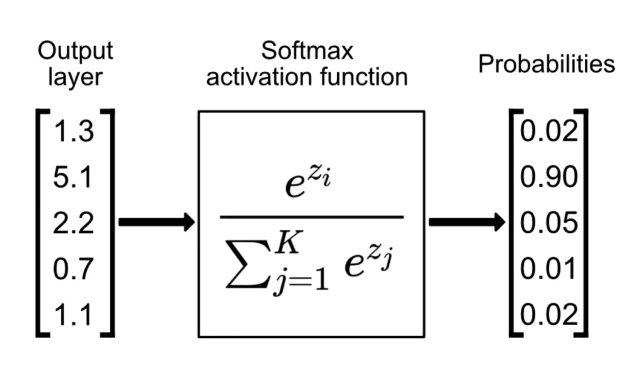

In [19]:
counts = logits.exp()
prob = counts/ counts.sum(1,keepdims=True)

In [20]:
prob[0].sum() ## Check if is normalized

tensor(1.)

In [89]:
## Clean a little bit more the code
g = torch.Generator().manual_seed(2147483647) ## We use a seed for reproducibility
C= torch.randn(27,10, generator=g) ## Each 27 chars would have a 2 dim embedding
W1 = torch.randn((30,200), generator=g)
b1=torch.randn(200, generator=g)
W2=torch.randn((200,27), generator=g)
b2=torch.randn(27, generator=g)
parameters = [C,W1,b1,W2,b2]

In [90]:
sum(p.nelement() for p in parameters) ## Number of total parameters

11897

embedding: (32, 3, 2) -> Input Features: (N,6) -> hidden_layer: (N,100) -> output_features: (100,27)

In [91]:
Xtr.shape, Ytr.shape

(torch.Size([182580, 3]), torch.Size([182580]))

To perform a backward (backpropagation) operation each tensor should be inside a computation graph

In [92]:
for p in parameters:
  p.requires_grad= True

In [93]:
lri=[]
lossi=[]
for i in range(100000):
  # minibatch construct
  ix = torch.randint(0,Xtr.shape[0],(32,))

  ## forward pass
  emb = C[Xtr[ix]] ## (32, 3, 2)
  hidden_layer = torch.tanh(emb.view(-1,30) @ W1 + b1) # would result in (-1,100)
  logits = hidden_layer @ W2 + b2
  counts = logits.exp()
  prob = counts/ counts.sum(1,keepdims=True)
  loss = F.cross_entropy(logits,Ytr[ix]) #log maximum likelihood

  ##backward pass
  for p in parameters:
    p.grad = None ## Nullify gradients

  loss.backward()
  lr = 0.1
  for p in parameters:
    p.data += -lr * p.grad

print(loss.item())

2.27785325050354


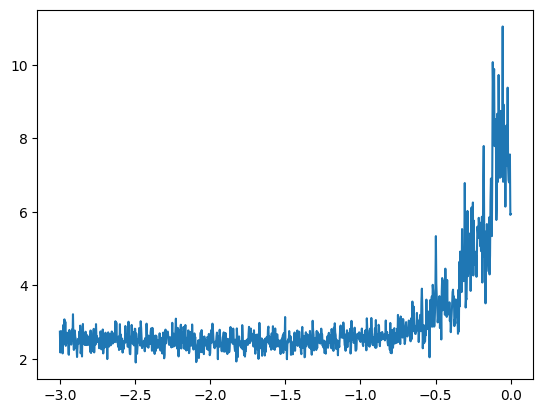

In [62]:
plt.plot(lri,lossi)

In [ ]:
## training split, dev/validation split, test split
## 80% , 10% , 10%

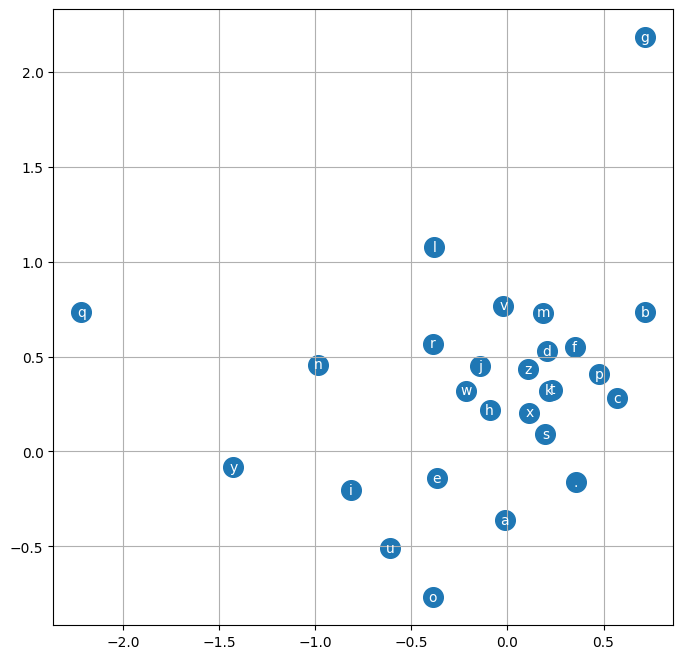

In [79]:
plt.figure(figsize=(8,8))
plt.scatter(C[:,0].data,C[:,1].data,s=200)
for i in range(C.shape[0]):
  plt.text(C[i,0].item(),C[i,1].item(),itos[i],ha="center",va="center",color="white")

plt.grid("minor")